In [1]:
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## $\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_y N}{\partial y} +  \frac{\partial c_\sigma N}{\partial \sigma}+ \frac{\partial c_\theta N}{\partial \theta}  = \frac{S(\sigma, \theta, t)}{\sigma}$



## Uniform coastline:

Assuming coast line that varies along x direction but is uniform in y, mathematically meaning:

$\frac{\partial N}{\partial y} = 0$ and $\frac{\partial c_{y}}{\partial y} = 0$

likewise in $\theta$

$\frac{\partial N}{\partial \theta} = 0$ and $\frac{\partial c_{\theta}}{\partial \theta} = 0$

Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_\sigma N}{\partial \sigma}+  = \frac{S(x, \sigma, t)}{\sigma}$

In this specific script we will perform the test as seen in ONR test bed case A21

## Case A21

"An infinitely long plane beach with parallel depth contours (slope 1:200) is considered. The x-axis is normal to the depth contours (see Figure 7). At a water depth of 20m, monochromatic, uni- directional waves enter the model area. At the up-wave boundary the incoming waves propagate at an angle of 0° relative to the positive x-axis. The distance of the up-wave boundary to the waterline is 4000 m. The incident wave height Hi and period Ti are 1 m and 10 s respectively.
Ambient currents and wind are absent."

## Conditions
In the SWAN computation this harmonic wave is simulated with a Gaussian-shaped frequency spectrum with peak
frequency 0.1 Hz, standard deviation 0.01 Hz, and a resolution
of 3% of the frequency (diffusion in frequency space does not
occur as $c_{\sigma}$= 0 in this case, and the frequency resolution may
therefore be somewhat coarse). The long crestedness in this
computation is simulated with a $cos^{500} (\theta)$ directional distribution (the directional width $\sigma_{\theta} = 2.5 $ degrees, where su is the standard
deviation of the directional distribution



## Solution

$\frac{H^2}{H_i^2}=\frac{c_{g,i}cos(\theta_i)}{c_g cos(\theta)}$

Where $H_i$ , $c_{g,i}$, $\theta_i$ is the boundary condition that remains steady through time

In [2]:
#define functions for both cartesian and non-cartesian
#this expression requires sigma to be in second index
def Gauss_Expression_1D(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3)',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak)
    return E
def Gauss_IC(F_peak,F_std,HS,x,sigmas):
    #takes in dof and paramters
    #returns vector with initial condition values at global DOF
    aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    tol=1e-14
    E = (x<tol)*aux1*np.exp(-(sigmas - 2*np.pi*F_peak)**2/aux3)
    return E
def Gauss_Expression_IC(F_peak,F_std,HS):
    aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    tol=1e-14
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('x[0] < tol ? aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3): 0',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak,tol=tol)
    return E
#an Expression class to evaluate u(x,y) on the 1D domain (range y, x fixed)
#maybe modify so input can determine if we want range y (fixed x) or range x (fixed y)
#this case want space to be x, sigma to be y
class my1DExpression(UserExpression):
    def __init__(self,u_2d,x,**kwargs):
        super().__init__(**kwargs)
        self.u_2d=u_2d
        self.x=x
        #Expression.__init__(self)
        self._vx= np.array([0.])
        self._pt_x= np.array([0.,0.])
    def eval(self, values, x):
        self._pt_x[0]= self.x
        self._pt_x[1]= x[0]
        self.u_2d.eval(self._vx,self._pt_x)
        values[0] = self._vx[0]
        
#need a function to calculate wave speed (phase and group) and wavenumber
def swan_calc_wavespeeds_k(sigmas,depths,g=9.81):
    #taken from Jessica's code
    cg_out=np.zeros(len(sigmas))
    k_out=np.zeros(len(sigmas))
    WGD=np.sqrt(depths/g)*g
    SND=sigmas*np.sqrt(depths/g)
    
    shallow_range=np.argwhere(SND<1e-6)
    mid_range=np.argwhere((SND<2.5)&(SND>=1e-6))
    deep_range=np.argwhere(SND>=2.5)
    
    def cg_mid(SND,g,depths,sigmas):
        SND2=SND*SND
        C=np.sqrt(g*depths/(SND2 +1/(1+0.666*SND2+.445*SND2**2 
                                     - 0.105*SND2**3 + 0.272*SND2**4)))
        KND=sigmas*depths/C
        
        FAC1=2*KND/np.sinh(2*KND)
        N=0.5*(1+FAC1)
        return N*C,sigmas/C
    def cg_deep(g,sigmas):
        return 0.5*g/sigmas
    def cg_shallow(WGD):
        return WGD

    cg_out[shallow_range]=cg_shallow(WGD[shallow_range])
    k_out[shallow_range]=SND[shallow_range]/depths[shallow_range]
    cg_out[mid_range],k_out[mid_range]=cg_mid(SND[mid_range],g,depths[mid_range],sigmas[mid_range])
    cg_out[deep_range]=cg_deep(g,sigmas[deep_range])
    k_out[deep_range]=sigmas[deep_range]**2/g

    return cg_out,k_out

def calc_c_sigma(sigmas,k,depths,c_g,currents,z_coords,loc_num):
    ##Inputs
    #sigmas - takes in a vector of sigma values (sigma coordinate at each d.o.f) at one point in physical spaxe
    #thetas
    #k - wavenumber corresponding to the given sigmas and thetas
    #c_g - corresponding group velocity
    #(note sigmas, thetas,k,c_g should all be same length which is number of d.o.f in one 2D slice)
    #depths - depths in meters of ALL physical coordinates (not just current one)
    #z_coords - unique coordinates in physical space (not just current one)
    #currents - water velocity at ALL physical coordinates
    #loc_num - the number of the physical point (starts at 0)
    #(note depths,z_coords,currents should all be same length which is the number of unique points in physical space)
    ##Outputs
    #outputs a vector same size as sigmas that is the c_sigma at all d.o.f in ONE 2D slice 
    #of the 3D domain corresponding to a single point in physical space for c_theta and c_sigma
    
    #for now assuming H is constant in time but can fix this later
    dHdt=0.0
    dHdy = 0.0
    dudy = 0.0
    dvdx = 0.0 #migh not have to be 0, well see
    dvdy = 0.0
    
    #also going to assume v is zero but maybe can change this later
    v=0.0
    u=0.0#currents[loc_num]
    H=depths#[loc_num]
    #calc gradient of H w.r.t. x
    #this is just forward euler but only works for fixed geometry
    #instead we'll hard code for this case
    dHdx=-1.0/200.0
    dudx=0.0
    '''
    if loc_num == 0:
        dHdx =(depths[loc_num+1]-H)/(z_coords[loc_num+1]-z_coords[loc_num])
        dudx = (currents[loc_num+1]-u)/(z_coords[loc_num+1]-z_coords[loc_num])
    elif loc_num == len(z_coords)-1:
        dHdx = (H-depths[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
        dudx = (u-currents[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
    else:
        dHdx = (depths[loc_num+1]-depths[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
        dudx = (currents[loc_num+1]-currents[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
    '''
    
    #now calculate velocity vectors
    c_sigma = k*sigmas/(np.sinh(2*k*H)) *(dHdt + u*dHdx + v*dHdy) - c_g*k*(dudx)
    #c_theta = sigmas/(np.sinh(2*k*H))*(dHdx*np.sin(thetas)- dHdy*np.cos(thetas)) + \
    #    dudx*np.cos(thetas)*np.sin(thetas) - dudy*(np.cos(thetas)**2) + dvdx*(np.sin(thetas)**2) \
    #    -dvdy*np.cos(thetas)*np.sin(thetas)
    return c_sigma #,c_theta

def calc_dc_dsigma(c_g,c_sigma,k,depths):
    #hard code the derivatives for now
    #for now assuming H is constant in time but can fix this later
    dHdt=0.0
    dHdy = 0.0
    dudy = 0.0
    dvdx = 0.0 #migh not have to be 0, well see
    dvdy = 0.0
    
    #also going to assume v is zero but maybe can change this later
    v=0.0
    u=0.0#currents[loc_num]
    H=depths#[loc_num]
    #calc gradient of H w.r.t. x
    #this is just forward euler but only works for fixed geometry
    #instead we'll hard code for this case
    dHdx=-1.0/200.0
    dudx=0.0
    #let's try this just to see what happens, may need to be changed in future
    dc_dsigma = k/(np.sinh(2*k*H)) *(dHdt + u*dHdx + v*dHdy) - c_g*k*(dudx)
    
    return dc_dsigma

In [3]:
###
###
###
#all functions relating to Cartesian product
def cartesian_product_dofs(array1,array2):
    #gives cartesian product of 2 1d vectors
    dim1=len(array1)
    dim2=len(array2)
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr

def cartesian_product_coords(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n1=array1.shape
    dim2,n2=array2.shape
    out_arr=np.zeros((dim1*dim2,n1+n2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            #print(array1[a,:])
            #print(array2[b,:])
            out_arr[c,:]=np.append(array1[a,:],array2[b,:])
            c=c+1
    return out_arr

def cartesian_form_to_kroneck_form(indeces, len_dim_2):
    #designed to take list of indexes in the cartesian form
    #translate to single form as kron product would
    #only for cartesian product between 2 spaces
    #expects matrix with n rows, 2 columns
    num_indeces=indeces.shape[0]
    out_arr=np.zeros(num_indeces)
    for n in range(num_indeces):
        out_arr[n] = indeces[n,0]*len_dim_2 + indeces[n,1]
    return out_arr

def spec_mult(c,K):
    len_dof=len(c)
    for i in range(len_dof):
        for j in range(len_dof):
            K[i,j] = (c[i]+c[j])/2*K[i,j]
    return K

def fetch_boundary_dofs(V1,V2,dof_coordinates1,dof_coordinates2):
    #outputs a vector of equation numbers in global system that are on the global boundary
    #input, the two function spaces of the subdomains in the cartesian product
    
    #use this to mark boundary (Dirichlet) 
    def boundary(x, on_boundary):
        return on_boundary

    #This function is simply used to mark the boundary (not the actual boundary condition)
    u_D1 = Expression('1.0', degree=1)

    #establish dummy functions
    dum1=Function(V1)
    dum2=Function(V2)
    #get entire boundary
    bc1 = DirichletBC(V1, u_D1, boundary)
    bc2 = DirichletBC(V2, u_D1, boundary)

    #apply to vectors to mark boundaries
    bc1.apply(dum1.vector())
    bc2.apply(dum2.vector())

    #get index number for each boundary cooordinates in subdomain
    boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
    boundary_dofs2 = np.where(dum2.vector()==1.0)[0]
  
    #coordinates of boundary in each subdomain (just for checking)
    boundary_coord1 = dof_coordinates1[boundary_dofs1]
    boundary_coord2 = dof_coordinates2[boundary_dofs2]

    #now create array of global boundary dof numbers
    global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

    ctr=0
    for j in boundary_dofs1:
        global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
        cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
        ctr=ctr+1

    last_ind = (ctr)*len(dof_coordinates2)


    for j in boundary_dofs2:
        global_boundary_dofs[last_ind:last_ind+len(dof_coordinates1),:] = \
        cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
        last_ind = last_ind+len(dof_coordinates1)    
    
    #sorts and also eliminates duplicates of "corners"
    global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)

    #have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
    #now need to convert to global system dof as the kron function does
    global_boundary_dofs=cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
    global_boundary_dofs=global_boundary_dofs.astype(int)
    return global_boundary_dofs
    

# For comparison, use FEniCS to solve without Cartesian Product

In [10]:
#define domain
omega_min=0.25 #smallest rad. frequency (needs to be larger than 0)
omega_max = 2.0 #largest rad. frequency
n_sigma = 30 #number of elements in frequncy which is dimension no. 0   
#should be 4000 (need to truncate a bit due to problem at 0 elevation)
n_space=100 #number of elements along coastline
space_len=3950 #distance of physical domain in meters

#create mesh, should only need 2d. no theta or second space dimension necessary
mesh=RectangleMesh(Point(0,omega_min),Point(space_len,omega_max),n_space,n_sigma)
#define function space
V = FunctionSpace(mesh, 'P' , 1)
#create test and trialfunctions
u_trial = TrialFunction(V)
v = TestFunction(V)

#tabulate degree of freedom coordinates
dof_coordinates=V.tabulate_dof_coordinates()
n=V.dim()
d=mesh.geometry().dim()
dof_coordinates.resize((n,d))

x = dof_coordinates[:,0] #dof in space
sigmas = dof_coordinates[:,1] #dof in frequency

#calculate depths for  this test case
depths=20-x/200

#initial/boundary conditions (for now, GAUSS only)
F_peak=0.1
F_std=0.1
HS=1

#compute propagation speeds
C1 = Function(V)
C2 = Function(V)

#calculate group velocities and wavenumbers pointwise
c_g,k=swan_calc_wavespeeds_k(sigmas,depths,g=9.81)
C1.vector()[:]=c_g

#calculate sigma velocity
currents = np.zeros(depths.shape)
lat_coords=np.unique(x)
ctr=0
c_sigmas=calc_c_sigma(sigmas,k,depths,c_g,currents,lat_coords,ctr)
C2.vector()[:] = c_sigmas

c = as_vector([C1,C2])

#now assign initial condition
B=Gauss_Expression_IC(F_peak,F_std,HS)
u_n=interpolate(B,V)
#calculate normals
n = FacetNormal(mesh)

#define time step
T=1000 #final time
num_steps=200 #number of steps
dt=T/num_steps

#just do basic Galerkin for this case
A = u_trial*v*dx - dt*dot(c*u_trial,grad(v))*dx + dt*dot(c*u_trial,n)*v*ds
L = u_n*v*dx

##comment this block out to ignore supg term
hmax=mesh.hmax()
tau=hmax/dot(c,c)**0.5
n=FacetNormal(mesh)
##here is mass conserving SUPG
A=A+inner(u_trial + dt*nabla_div(c*u_trial), tau*dot(c,grad(v)))*dx
L = L + u_n*tau*dot(c,grad(v))*dx
##here is non
##A=A+inner(u_trial + dt*nabla_div(c*u_trial), tau*nabla_div(c*v))*dx
##L = L + u_n*tau*nabla_div(c*v)*dx

#define and apply BC
def incoming_boundary(x,on_boundary):
    return on_boundary and (near(x[0],0, 1e-14))
u_D=Gauss_Expression_1D(F_peak,F_std,HS)
bc = DirichletBC(V,u_D,incoming_boundary,"geometric") #need geometric for DG, otherwise not necessa

u = Function(V)

A = assemble(A)

bc.apply(A)


#make explicit matrices for comparison purposes
A = np.array(A.array())



A_inv = np.linalg.inv(A)
for t in range(num_steps):
    
    L1=assemble(L)
    bc.apply(L1)
    RHS = np.array(L1)
    #solve for new time step
    u_vec=np.matmul(A_inv,RHS)
    
    #need too rebuild RHS each time
    u.vector()[:]=u_vec
    u_n.assign(u)


0.0
39.5
79.0
118.5
158.0
197.5
237.0
276.5
316.0
355.5
395.0
434.5
474.0
513.5
553.0
592.5
632.0
671.5
711.0
750.5
790.0
829.5
869.0
908.5
948.0
987.5
1027.0
1066.5
1106.0
1145.5
1185.0
1224.5
1264.0
1303.5
1343.0
1382.5
1422.0
1461.5
1501.0
1540.5
1580.0
1619.5
1659.0
1698.5
1738.0
1777.5
1817.0
1856.5
1896.0
1935.5
1975.0
2014.5
2054.0
2093.5
2133.0
2172.5
2212.0
2251.5
2291.0
2330.5
2370.0
2409.5
2449.0
2488.5
2528.0
2567.5
2607.0
2646.5
2686.0
2725.5
2765.0
2804.5
2844.0
2883.5
2923.0
2962.5
3002.0
3041.5
3081.0
3120.5
3160.0
3199.5
3239.0
3278.5
3318.0
3357.5
3397.0
3436.5
3476.0
3515.5
3555.0
3594.5
3634.0
3673.5
3713.0


3752.5
3792.0
3831.5
3871.0
3910.5
3950.0
[  9.99945612e-01   7.48212751e-09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000

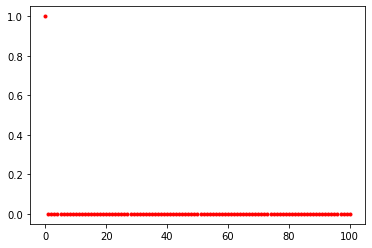

In [7]:
Hs_vec=np.zeros(len(lat_coords))
i=0
#calc Hs at each point in physical space
m_1D=IntervalMesh(n_sigma,omega_min,omega_max)
V_1D=FunctionSpace(m_1D, "CG",1)
i=0
for lat in lat_coords:
    print(lat)

    test1=my1DExpression(u,x=lat)
    Uy=interpolate(test1,V_1D)
    intUy=4*np.sqrt(assemble(Uy*dx))
    Hs_vec[i]=intUy
    i=i+1

#plot(Uy)
#print(intUy)
plt.plot(Hs_vec,'r.')
print(Hs_vec)

['YP', 'Hs', 'Dir', 'Dep', 'K', 'Cg', 'C']


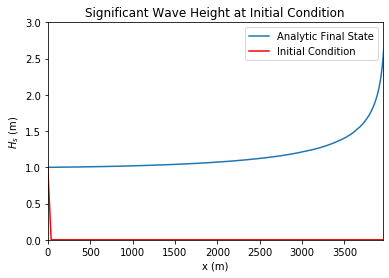

In [9]:
#attempt to read in analytic
fname='Shoaling_Analytic.txt'
f=open(fname,"r")
lines=f.readlines()
f.close()
column_names=lines[0].split()
print(column_names)
A=np.zeros((999,len(column_names))) #should be 1000, but last row is garbage
ctr=0
for line in lines[2:-1]:
    A[ctr,:]=line.split()
    ctr+=1

#now plot
plt.plot(A[:,0],A[:,1],label='Analytic')
plt.title('Significant Wave Height ($C^0 approach with SUPG$)')
plt.xlim((0,3950))
plt.ylim((0,3))
plt.plot(lat_coords,Hs_vec,'r',label='FEM')
plt.xlabel('x (m)')
plt.ylabel('$H_s$ (m)')
plt.legend()
#plt.savefig('HS_IC.png')

# OK now try same exact thing but using Cartesian Product

In [4]:
#define domain
omega_min=0.25 #smallest rad. frequency (needs to be larger than 0)
omega_max = 2.0 #largest rad. frequency
n_sigma = 30 #number of elements in frequncy which is dimension no. 0   
#should be 4000 (need to truncate a bit due to problem at 0 elevation)
n_space=100 #number of elements along coastline
space_len=3950 #distance of physical domain in meters

#define time step
T=1000 #final time
num_steps=int(200) #number of steps
dt=T/num_steps

#create 2 meshes
mesh1 = IntervalMesh(n_space,0,space_len)
mesh2 = IntervalMesh(n_sigma,omega_min,omega_max)

V1 = FunctionSpace(mesh1, 'P', 1)
V2 = FunctionSpace(mesh2, 'P', 1)
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V2.tabulate_dof_coordinates()
N_dof_1 = len(dof_coordinates1)
N_dof_2 = len(dof_coordinates2)
print(N_dof_1)
print(N_dof_2)

#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=cartesian_product_coords(dof_coordinates1,dof_coordinates2)
#split into x,sigma
x = global_dof[:,0]
#calculate depths for  this test case
depths=20-x/200
sigmas = global_dof[:,1]

#create trial and test functions
u1_trial = TrialFunction(V1)
v1_test = TestFunction(V1)
u2_trial = TrialFunction(V2)
v2_test = TestFunction(V2)

#generate weak forms
n1=FacetNormal(mesh1)
n2=FacetNormal(mesh2)



global_boundary_dofs = fetch_boundary_dofs(V1,V2,dof_coordinates1,dof_coordinates2)



#now manually for now select only left as incoming boundary
dum1 = global_boundary_dofs[x[global_boundary_dofs]<=(1e-14)]
global_boundary_dofs = np.unique(dum1)

#print boundary coordinates just to check
print(x[global_boundary_dofs])
print(sigmas[global_boundary_dofs])
print(global_boundary_dofs)


#initial/boundary conditions (for now, GAUSS only)
F_peak=0.1
F_std=0.1
HS=1


#calculate group velocities and wavenumbers pointwise
c_g,k=swan_calc_wavespeeds_k(sigmas,depths,g=9.81)
#calculate sigma velocity
currents = np.zeros(depths.shape)
lat_coords=np.unique(x)
ctr=0
c_sigmas=calc_c_sigma(sigmas,k,depths,c_g,currents,lat_coords,ctr)

#compute initial condition
N_i = Gauss_IC(F_peak,F_std,HS,x,sigmas)


#now assemble global system
#define velocities
cx_func = Function(V1)
c_sig_func = Function(V1)

####################################
##only used in SUPG stabilization
#'''
#this is provisionary, may need to change later, but use analytic dervative of dc_sigma/dsigma
dc_dsigma = calc_dc_dsigma(c_g,c_sigmas,k,depths)
dc_dsig_func = Function(V1)
#compute hmax for tau, since uniform this should be a constant
hmax1=mesh1.hmax()
hmax2=mesh2.hmax()
hmax = Constant(np.sqrt(hmax1**2 + hmax2**2))
tau = Function(V1)
#tau will have to be a global function since it varies in x and y
#tau=hmax/dot(c,c)**0.5
SUPG_M1 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
SUPG_M2 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
SUPG_A1 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
SUPG_A2 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
SUPG_A3 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
SUPG_A4 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
#'''
####################################


A = np.zeros((N_dof_1*N_dof_2,N_dof_1*N_dof_2))
F = np.zeros((N_dof_1*N_dof_2,N_dof_1*N_dof_2))
A1 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
A2 = np.zeros((N_dof_1,N_dof_1,N_dof_2))
A3 = np.zeros((N_dof_1,N_dof_1,N_dof_2))

for a in range(N_dof_2):
    #have expression for cx and csigma
    #need value at a specific dof_coordinate in second domain
    #this should be right
    cx_func.vector()[:] = np.array(c_g[a::N_dof_2])
    c_sig_func.vector()[:] = np.array(c_sigmas[a::N_dof_2])
    #create expressions and assemble linear forms
    K11 = cx_func*u1_trial*v1_test.dx(0)*dx
    K12 = c_sig_func*u1_trial*v1_test*dx
    K13 = cx_func*dot(n1,as_vector((u1_trial,)))*v1_test*ds
    
    #then save all matrices to list of matrices
    K11 = assemble(K11)
    K12 = assemble(K12)
    K13 = assemble(K13)
    
    A1[:,:,a] = np.array(K11.array())
    A2[:,:,a] = np.array(K12.array())
    A3[:,:,a] = np.array(K13.array())
    
    #####################################
    #SUPG part only
    #'''
    c=as_vector([cx_func,c_sig_func])
    dc_dsig_func.vector()[:] = np.array(dc_dsigma[a::N_dof_2])
    tau = hmax/dot(c,c)**0.5
    
    #supg terms
    K11 = tau*cx_func*u1_trial*v1_test.dx(0)*dx
    K12 = tau*c_sig_func*u1_trial*v1_test*dx
    K13 = tau*(cx_func.dx(0)*cx_func*u1_trial*v1_test.dx(0) + cx_func*cx_func*u1_trial.dx(0)*v1_test.dx(0) \
              + dc_dsig_func*cx_func*u1_trial*v1_test.dx(0))*dx
    K14 = tau*(cx_func.dx(0)*c_sig_func*u1_trial*v1_test + cx_func*c_sig_func*u1_trial.dx(0)*v1_test + \
              dc_dsig_func*cx_func*u1_trial*v1_test)*dx
    K15 = tau*c_sig_func*cx_func*u1_trial*v1_test.dx(0)*dx
    K16 = tau*c_sig_func*c_sig_func*u1_trial*v1_test*dx
    
    #assemble and store matrices
    K11 = assemble(K11)
    K12 = assemble(K12)
    K13 = assemble(K13)
    K14 = assemble(K14)
    K15 = assemble(K15)
    K16 = assemble(K16)
    SUPG_M1[:,:,a] = np.array(K11.array()) 
    SUPG_M2[:,:,a] = np.array(K12.array())
    SUPG_A1[:,:,a] = np.array(K13.array())
    SUPG_A2[:,:,a] = np.array(K14.array())
    SUPG_A3[:,:,a] = np.array(K15.array())
    SUPG_A4[:,:,a] = np.array(K16.array())
    #'''
    ######################################
    
#now define N_dof_1 x N_dof_1 functions to be integrated in domain 2
fy = Function(V2)
for i in range(N_dof_1):
    for j in range(N_dof_1):
        fy.vector()[:] = np.array(A1[i,j,:])
        K21 = u2_trial*v2_test*fy*dx
        K21 = assemble(K21)
        K21 = np.array(K21.array())
        
        
        fy.vector()[:] = np.array(A2[i,j,:])
        K22 = u2_trial*v2_test.dx(0)*fy*dx
        K22 = assemble(K22)
        K22 = np.array(K22.array())
        
        
        
        K23 = dot(n2,as_vector((u2_trial,)))*v2_test*fy*ds
        K23 = assemble(K23)
        K23 = np.array(K23.array())
        
        
        fy.vector()[:] = np.array(A3[i,j,:])
        K24 = u2_trial*v2_test*fy*dx
        K24 = assemble(K24)
        K24 = np.array(K24.array())
        
        ######################################################
        #SUPG Part
        #'''
        fy.vector()[:] = np.array(SUPG_M1[i,j,:])
        SUPG_1 = u2_trial*v2_test*fy*dx
        SUPG_1 = assemble(SUPG_1)
        SUPG_1 = np.array(SUPG_1.array())
        
        fy.vector()[:] = np.array(SUPG_M2[i,j,:])
        SUPG_2 = u2_trial*v2_test.dx(0)*fy*dx
        SUPG_2 = assemble(SUPG_2)
        SUPG_2 = np.array(SUPG_2.array())
        
        fy.vector()[:] = np.array(SUPG_A1[i,j,:])
        SUPG_3 = u2_trial*v2_test*fy*dx
        SUPG_3 = assemble(SUPG_3)
        SUPG_3 = np.array(SUPG_3.array())
        
        fy.vector()[:] = np.array(SUPG_A2[i,j,:])
        SUPG_4 = u2_trial*v2_test.dx(0)*fy*dx
        SUPG_4 = assemble(SUPG_4)
        SUPG_4 = np.array(SUPG_4.array())
        
        fy.vector()[:] = np.array(SUPG_A3[i,j,:])
        SUPG_5 = u2_trial.dx(0)*v2_test*fy*dx
        SUPG_5 = assemble(SUPG_5)
        SUPG_5 = np.array(SUPG_5.array())
        
        fy.vector()[:] = np.array(SUPG_A4[i,j,:])
        SUPG_6 = u2_trial.dx(0)*v2_test.dx(0)*fy*dx
        SUPG_6 = assemble(SUPG_6)
        SUPG_6 = np.array(SUPG_6.array())
        
        SUPG = SUPG_3 + SUPG_4 + SUPG_5 + SUPG_6
        A[i*N_dof_2:(i+1)*N_dof_2,j*N_dof_2:(j+1)*N_dof_2] = -dt*(K21 + K22) + dt*(K23+K24) + dt*SUPG
        
        F[i*N_dof_2:(i+1)*N_dof_2,j*N_dof_2:(j+1)*N_dof_2] = SUPG_1+SUPG_2
        #'''
        #####################################################
        #Uncomment if running Without SUPG
        #A[i*N_dof_2:(i+1)*N_dof_2,j*N_dof_2:(j+1)*N_dof_2] = -dt*(K21 + K22) + dt*(K23+K24)


K11 = u1_trial*v1_test*dx
K11 = assemble(K11)
K11 = np.array(K11.array())
K21 = u2_trial*v2_test*dx
K21 = assemble(K21)
K21 = np.array(K21.array())
F = F + np.kron(K11,K21)

A = A + F
RHS = F.dot(N_i)

#apply dirichlet BC
#and make RHS
#wipe out rows of global matrix that need to be dirichlet
K_bound = np.zeros(A.shape)
for i in global_boundary_dofs:
    K_bound[i,i] = 1
    
A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]

#now loop through time and solve
#since A doesnt change, invert first
print('condition number')
print(np.linalg.cond(A))
A_inv = np.linalg.inv(A)
for t in range(num_steps):
    #dirichlet BC
    RHS[global_boundary_dofs] = N_i[global_boundary_dofs]
    #solve in time
    #u=np.linalg.solve(A,RHS)
    u=np.matmul(A_inv,RHS)
    #assign new solution to previous time step
    RHS = F.dot(u)
    #update dirichlet boundary condition
    


101
31
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 2.          1.94166667  1.88333333  1.825       1.76666667  1.70833333
  1.65        1.59166667  1.53333333  1.475       1.41666667  1.35833333
  1.3         1.24166667  1.18333333  1.125       1.06666667  1.00833333
  0.95        0.89166667  0.83333333  0.775       0.71666667  0.65833333
  0.6         0.54166667  0.48333333  0.425       0.36666667  0.30833333
  0.25      ]
[3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114
 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129
 3130]
condition number
23.920347604


In [5]:
HS = np.zeros(n_space+1)
small_sigmas = dof_coordinates2[:,0]
for j in range(n_space+1):
    HS[j] = 4*np.sqrt(-np.trapz(u[j*(n_sigma+1):(j+1)*(n_sigma+1)],small_sigmas)) 
print(HS)

[ 2.438956    2.10267077  1.92554881  1.80705952  1.71909738  1.64994025
  1.5935129   1.54623533  1.50581882  1.47071532  1.43983272  1.41237443
  1.38774326  1.36548114  1.34522963  1.32670353  1.30967245  1.2939479
  1.2793738   1.26581963  1.2531752   1.24134671  1.2302537   1.21982668
  1.21000526  1.20073663  1.1919744   1.18367759  1.17580982  1.1683387
  1.16123525  1.15447343  1.14802979  1.14188314  1.13601424  1.13040562
  1.12504134  1.11990682  1.1149887   1.11027472  1.10575357  1.10141485
  1.09724891  1.09324683  1.08940034  1.08570175  1.08214389  1.07872009
  1.07542411  1.07225012  1.06919266  1.06624661  1.06340717  1.0606698
  1.05803027  1.05548456  1.0530289   1.05065971  1.04837362  1.04616744
  1.04403815  1.04198288  1.03999891  1.03808366  1.03623469  1.03444965
  1.03272633  1.03106261  1.02945648  1.02790601  1.02640937  1.02496481
  1.02357064  1.02222527  1.02092716  1.01967484  1.0184669   1.017302
  1.01617884  1.01509618  1.01405282  1.01304762  1.0120

['YP', 'Hs', 'Dir', 'Dep', 'K', 'Cg', 'C']


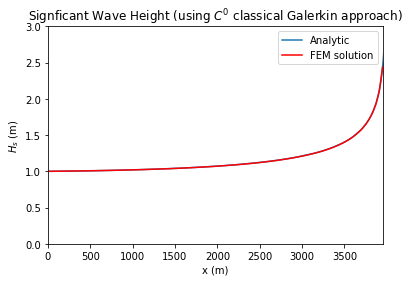

In [6]:
#attempt to read in analytic
fname='Shoaling_Analytic.txt'
f=open(fname,"r")
lines=f.readlines()
f.close()
column_names=lines[0].split()
print(column_names)
A=np.zeros((999,len(column_names))) #should be 1000, but last row is garbage
ctr=0
for line in lines[2:-1]:
    A[ctr,:]=line.split()
    ctr+=1

#now plot
plt.plot(A[:,0],A[:,1],label='Analytic')
plt.title('Signficant Wave Height (using $C^0$ classical Galerkin approach)')
plt.xlim((0,3950))
plt.ylim((0,3))
plt.plot(dof_coordinates1,HS,'r',label='FEM solution')
plt.xlabel('x (m)')
plt.ylabel('$H_s$ (m)')
plt.legend()
#plt.savefig('HS_classical_cart.png')

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 2.          1.94166667  1.88333333  1.825       1.76666667  1.70833333
  1.65        1.59166667  1.53333333  1.475       1.41666667  1.35833333
  1.3         1.24166667  1.18333333  1.125       1.06666667  1.00833333
  0.95        0.89166667  0.83333333  0.775       0.71666667  0.65833333
  0.6         0.54166667  0.48333333  0.425       0.36666667  0.30833333
  0.25      ]


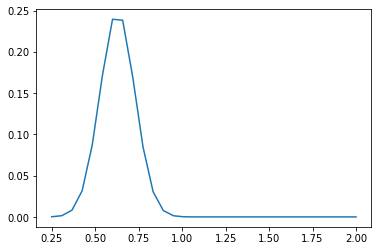

In [7]:
plt.plot(dof_coordinates2,u[global_boundary_dofs])
print(x[global_boundary_dofs])
print(sigmas[global_boundary_dofs])
